# SatLomas: Post-procesamiento U-Net (Sentinel-2)

In [43]:
import os
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import rasterio
from itertools import zip_longest
import subprocess
import tempfile
import math
import random

In [2]:
BASE_DIR = os.path.join(os.path.expanduser('~'), 'data', 'lomas', 's2')
RESULTS_DIR = os.path.join(BASE_DIR, 'train', '160_80', 'results', 'v10')

BINARIZE_RESULTS_DIR = os.path.join(RESULTS_DIR, 'bin')
MERGE_RESULTS_DIR = os.path.join(RESULTS_DIR, 'merge')

## Fusionar en una sola banda y binarizar

Para cada pixel, tomar la clase con máxima probabilidad entre las bandas (clases), binarizar con un umbral definido, y generar un raster binario con la clase asignado por pixel.

In [50]:
random.randint(0, 10)

2

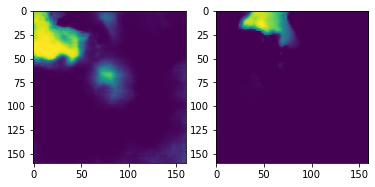

In [63]:
images = glob(os.path.join(RESULTS_DIR, '*.tif'))
# k = random.randint(0, len(images))
# print(k)
img_p = images[4989]
with rasterio.open(img_p) as src:
    img = np.dstack(src.read())

plt.subplot(121)
plt.imshow(img[:,:,0])

plt.subplot(122)
plt.imshow(img[:,:,1])

In [64]:
img.shape

(160, 160, 2)

In [65]:
mask_t = 0.4 * 255

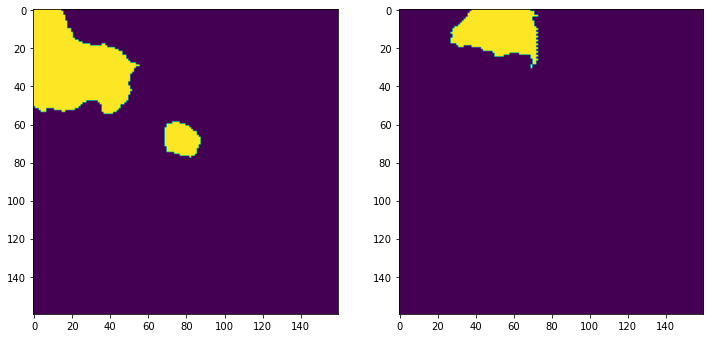

In [66]:
plt.figure(figsize=(12,8))
plt.subplot(121)
plt.imshow(img[:,:,0] >= mask_t)

plt.subplot(122)
plt.imshow(img[:,:,1] >= mask_t)

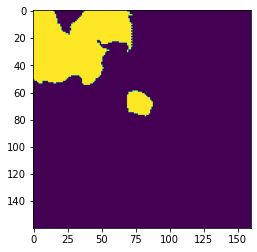

In [67]:
mask = ((img[:,:,0] >= mask_t) | (img[:,:,1] >= mask_t)).astype(np.uint8)
plt.imshow(mask)

In [68]:
max_img = (np.argmax(img, axis=2) + 1) * mask
print(max_img.shape)
max_img

(160, 160)


array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

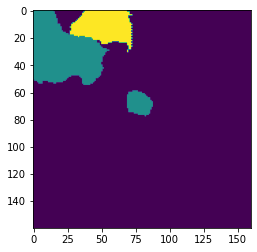

In [69]:
plt.imshow(max_img)

In [73]:
def coalesce_and_binarize(src_path, threshold=0.5, *, output_dir):
    with rasterio.open(src_path) as src:
        profile = src.profile.copy()
        img = np.dstack(src.read())
    
    mask_t = threshold * 255
    mask = ((img[:,:,0] >= mask_t) | (img[:,:,1] >= mask_t)).astype(np.uint8)
    max_img = ((np.argmax(img, axis=2) + 1) * mask).astype(np.uint8)
    
    dst_path = os.path.join(output_dir, os.path.basename(src_path))
    profile.update(count=1, nodata=0)
    with rasterio.open(dst_path, 'w', **profile) as dst:
        dst.write(max_img, 1)
    

def coalesce_and_binarize_all(threshold=0.75, *, input_dir, output_dir):
    images = glob(os.path.join(input_dir, '*.tif'))
    os.makedirs(output_dir, exist_ok=True)
    # TODO: Use multiprocessing
    for image in tqdm(images):
        coalesce_and_binarize(image, threshold=threshold, output_dir=output_dir)

In [294]:
coalesce_and_binarize_all(input_dir=RESULTS_DIR,
                          output_dir=os.path.join(RESULTS_DIR, 'bin'),
                          threshold=0.4)

100%|██████████| 8952/8952 [00:47<00:00, 189.34it/s]


## Fusionar rasters en uno solo

In [80]:
def run_subprocess(cmd):
    subprocess.run(cmd, shell=True, check=True)
    
def grouper(iterable, n, fillvalue=None):
    "Collect data into fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx"
    args = [iter(iterable)] * n
    return zip_longest(*args, fillvalue=fillvalue)

def gdal_merge(output, files):
    cmd = f"gdal_merge.py -n 0 -a_nodata 0 " \
        f"-co TILED=YES " \
        f"-o {output} {' '.join(files)}"
    run_subprocess(cmd)

def merge_all(batch_size=1000, temp_dir=None, *, input_dir, output):
    files = sorted(list(glob(os.path.join(input_dir, '*.tif'))))
    if not files:
        print("No files")

    tmpdir = None
    if not temp_dir:
        tmpdir = tempfile.TemporaryDirectory()
        temp_dir = tmpdir.name

    os.makedirs(temp_dir, exist_ok=True)

    merged_files = []
    total = math.ceil(len(files) / batch_size)
    for i, group in tqdm(enumerate(grouper(files, batch_size)), total=total):
        dst = os.path.join(temp_dir, f"{i}.tif")
        group = [f for f in group if f]            
        gdal_merge(dst, group)
        merged_files.append(dst)
    
    os.makedirs(os.path.dirname(output), exist_ok=True)
    if os.path.exists(output):
        os.unlink(output)
    gdal_merge(output, merged_files)

    if tmpdir:
        tmpdir.cleanup()

    print(f"{output} written")

In [307]:
merge_all(input_dir=os.path.join(RESULTS_DIR, 'bin'),
          output=os.path.join(RESULTS_DIR, 'final', 'merged.tif'),
          temp_dir=os.path.join(RESULTS_DIR, 'temp'))

100%|██████████| 9/9 [00:20<00:00,  2.31s/it]


/home/ro/data/lomas/ps1/train/320_320/results/v3/final/merged.tif written


## Clipear con area de análisis

In [89]:
def clip(*, src, dst, aoi):
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    if os.path.exists(dst):
        os.unlink(dst)    
    run_subprocess(f'gdalwarp -cutline {aoi} -co COMPRESS=DEFLATE -co TILED=YES {src} {dst}')

In [309]:
clip(src=os.path.join(RESULTS_DIR, 'final', 'merged.tif'),
     dst=os.path.join(RESULTS_DIR, 'final', 'clipped.tif'),
     aoi=os.path.join(BASE_DIR, 'train', 'raw', 'aoi.geojson'))

## Pipeline entero

In [90]:
def postprocess(input_dir, output):
    coalesce_and_binarize_all(input_dir=input_dir,
                              output_dir=os.path.join(input_dir, 'bin'),
                              threshold=0.2)
    merge_all(input_dir=os.path.join(input_dir, 'bin'),
              output=os.path.join(input_dir, 'final', 'merged.tif'))
    clip(src=os.path.join(input_dir, 'final', 'merged.tif'),
         dst=output,
         aoi=os.path.join(BASE_DIR, 'train', 'aoi.geojson'))

In [92]:
postprocess(os.path.join(BASE_DIR, 'predict', '160_160_20190411', 'results', 'v10'),
            os.path.join(BASE_DIR, 'predict', '160_160_20190411.tif'))

100%|██████████| 9/9 [00:14<00:00,  1.64s/it]


/home/ro/data/lomas/s2/predict/160_160_20190411/results/v10/final/merged.tif written


In [93]:
postprocess(os.path.join(BASE_DIR, 'predict', '160_160_20200420', 'results', 'v10'),
            os.path.join(BASE_DIR, 'predict', '160_160_20200420.tif'))

100%|██████████| 4/4 [00:06<00:00,  1.64s/it]


/home/ro/data/lomas/s2/predict/160_160_20200420/results/v10/final/merged.tif written
